In [10]:
import pandas as pd
import numpy as np
import os
import pickle

In [ ]:
from dotenv import load_dotenv,set_key

In [41]:
load_dotenv()
dotenv_path = ".env"

In [ ]:
TRACKING_SERVER_HOST = os.getenv('MLFLOW_TRACKING_URI')
print(TRACKING_SERVER_HOST)

In [ ]:
import boto3

# Initialize a session, optionally passing the region if necessary
session = boto3.Session(region_name='us-east-1')

# Get the credentials from the session
credentials = session.get_credentials().get_frozen_credentials()

# Get the region from the session
region = session.region_name

# Print credentials and region
# print(f"AWS Access Key ID: {credentials.access_key}")
# print(f"AWS Secret Access Key: {credentials.secret_key}")
# print(f"AWS Region: {region}")

s3_client = session.client('s3')

In [15]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn import *


In [16]:
import mlflow


In [17]:

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")
mlflow.set_experiment("spanish_energy_price_prediction")

<Experiment: artifact_location='s3://mlflow-artifacts-remote23/839689426251288043', creation_time=1727998548088, experiment_id='839689426251288043', last_update_time=1727998548088, lifecycle_stage='active', name='spanish_energy_price_prediction', tags={}>

In [18]:
# Reading the data in a pandas dataframe
df = pd.read_csv("data/energy_dataset.csv")

In [19]:
df['time'].nunique()


35064

In [20]:
df.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,...,35045.000000,35046.0,35046.000000,35064.000000,0.0,35064.000000,35064.000000,35028.000000,35064.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,...,269.452133,0.0,5464.479769,1439.066735,NaN,5471.216689,28712.129962,28696.939905,49.874341,57.884023
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,...,50.195536,0.0,3213.691587,1677.703355,NaN,3176.312853,4594.100854,4574.987950,14.618900,14.204083
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,...,0.000000,0.0,0.000000,0.000000,NaN,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,...,240.000000,0.0,2933.000000,69.000000,NaN,2979.000000,24793.750000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,...,279.000000,0.0,4849.000000,576.000000,NaN,4855.000000,28906.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,...,310.000000,0.0,7398.000000,2636.000000,NaN,7353.000000,32263.250000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,...,357.000000,0.0,17436.000000,5836.000000,NaN,17430.000000,41390.000000,41015.000000,101.990000,116.800000


In [21]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,time,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_coal-derived_gas,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_fossil_oil_shale,generation_fossil_peat,generation_geothermal,...,generation_waste,generation_wind_offshore,generation_wind_onshore,forecast_solar_day_ahead,forecast_wind_offshore_eday_ahead,forecast_wind_onshore_day_ahead,total_load_forecast,total_load_actual,price_day_ahead,price_actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [22]:
zero_val_cols = ['generation_marine',
                 'generation_geothermal',
                 'generation_fossil_peat',
                 'generation_wind_offshore',
                 'generation_fossil_oil_shale',
                 'forecast_wind_offshore_eday_ahead',
                 'generation_fossil_coal-derived_gas',
                 'generation_hydro_pumped_storage_aggregated']
df = df.drop(zero_val_cols, axis=1)
df = df.drop('time', axis=1)

In [23]:
#Deleting the empty columns
df.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

Correlation coefficients with target variable (price_actual):
price_actual                                   1.000000
price_day_ahead                                0.732155
generation_fossil_hard_coal                    0.465637
generation_fossil_gas                          0.461452
total_load_forecast                            0.435864
total_load_actual                              0.435253
generation_fossil_brown_coal/lignite           0.363993
generation_fossil_oil                          0.285050
generation_other_renewable                     0.255551
generation_waste                               0.168710
generation_biomass                             0.142671
forecast_solar_day_ahead                       0.101402
generation_other                               0.099914
generation_solar                               0.098529
generation_hydro_water_reservoir               0.071910
generation_nuclear                            -0.053016
generation_hydro_run-of-river_and_poundage

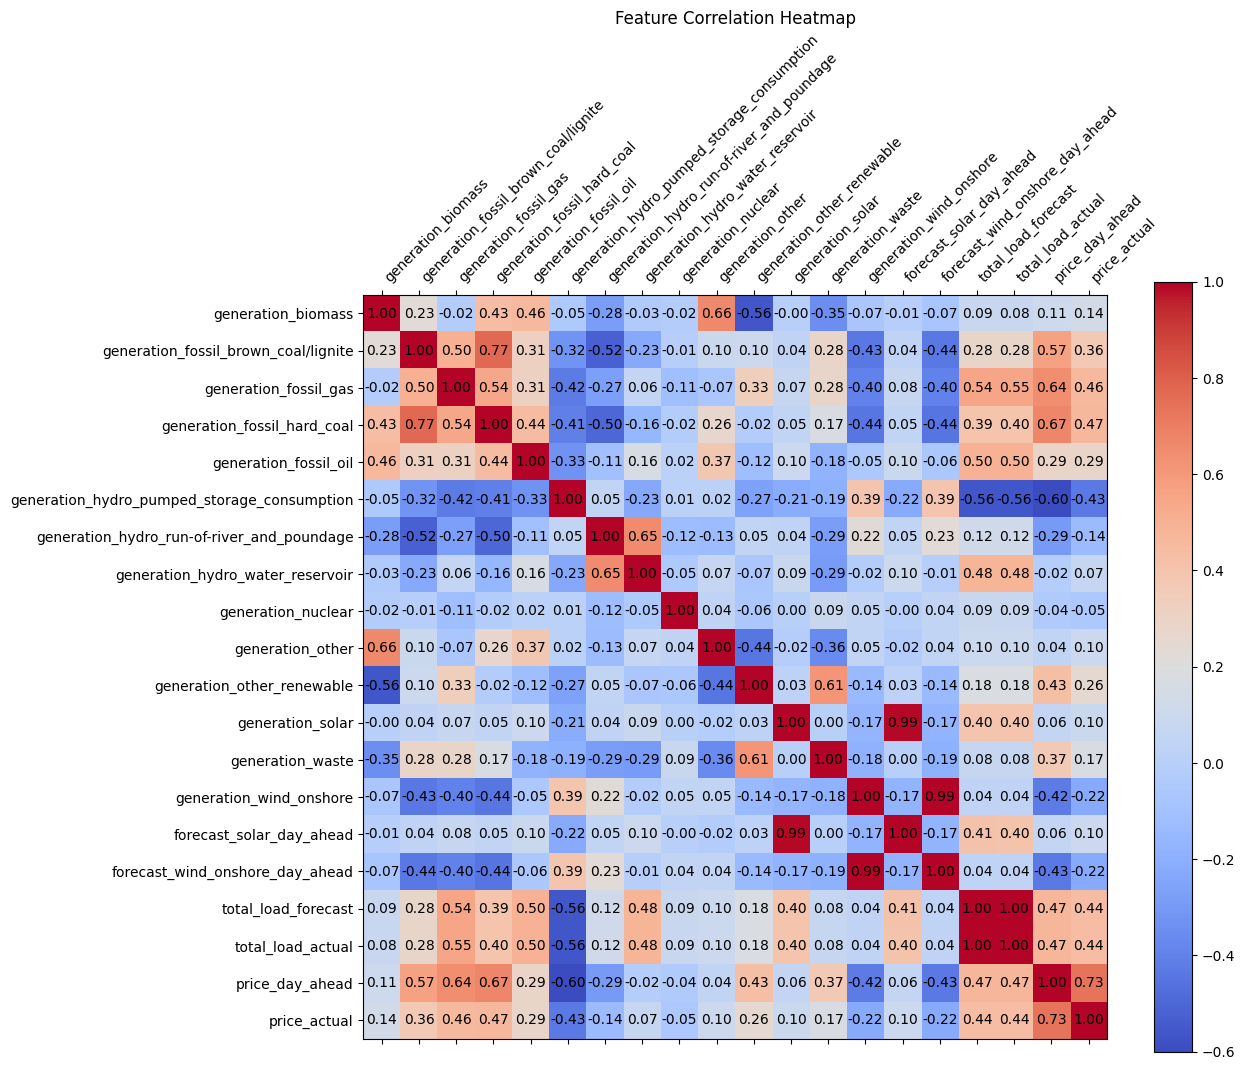

In [24]:
import matplotlib.pyplot as plt

# Calculate correlation matrix
correlation_matrix = df.corr()

# Filter to see correlation of all features with target variable 'price_actual'
target_correlation = correlation_matrix['price_actual'].sort_values(ascending=False)

# Display correlation values
print("Correlation coefficients with target variable (price_actual):")
print(target_correlation)

fig, ax = plt.subplots(figsize=(12, 10))

# Create the heatmap
cax = ax.matshow(correlation_matrix, cmap='coolwarm')

# Add color bar
fig.colorbar(cax)

# Set ticks and labels
ax.set_xticks(np.arange(len(correlation_matrix.columns)))
ax.set_yticks(np.arange(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns, rotation=45, ha='left')
ax.set_yticklabels(correlation_matrix.columns)

# Display the correlation coefficients on the heatmap
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        text = ax.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
                       ha="center", va="center", color="black")

# Add title
plt.title("Feature Correlation Heatmap")
plt.show()

In [25]:
correlation_with_target = df.corr()['price_actual'].sort_values(ascending=False)
print(correlation_with_target)

price_actual                                   1.000000
price_day_ahead                                0.732155
generation_fossil_hard_coal                    0.465637
generation_fossil_gas                          0.461452
total_load_forecast                            0.435864
total_load_actual                              0.435253
generation_fossil_brown_coal/lignite           0.363993
generation_fossil_oil                          0.285050
generation_other_renewable                     0.255551
generation_waste                               0.168710
generation_biomass                             0.142671
forecast_solar_day_ahead                       0.101402
generation_other                               0.099914
generation_solar                               0.098529
generation_hydro_water_reservoir               0.071910
generation_nuclear                            -0.053016
generation_hydro_run-of-river_and_poundage    -0.136659
generation_wind_onshore                       -0

In [26]:
df['total_fossil_generation'] = (
    df['generation_fossil_hard_coal'] +
    df['generation_fossil_gas'] +
    df['generation_fossil_oil'] +
    df['generation_fossil_brown_coal/lignite']
)


In [27]:
correlation_with_target = df.corr()['price_actual'].sort_values(ascending=False)
print(correlation_with_target)

price_actual                                   1.000000
price_day_ahead                                0.732155
total_fossil_generation                        0.526189
generation_fossil_hard_coal                    0.465637
generation_fossil_gas                          0.461452
total_load_forecast                            0.435864
total_load_actual                              0.435253
generation_fossil_brown_coal/lignite           0.363993
generation_fossil_oil                          0.285050
generation_other_renewable                     0.255551
generation_waste                               0.168710
generation_biomass                             0.142671
forecast_solar_day_ahead                       0.101402
generation_other                               0.099914
generation_solar                               0.098529
generation_hydro_water_reservoir               0.071910
generation_nuclear                            -0.053016
generation_hydro_run-of-river_and_poundage    -0

In [28]:
target = 'price_actual'
threshold = 0.1
correlations = df.corr()[target]
selected_features = correlations[correlations.abs()>0].index.tolist()
selected_features.remove(target)

In [29]:
first_row = df.iloc[0]
ride = {col: first_row[col] for col in df.columns}
print(ride)

{'generation_biomass': np.float64(447.0), 'generation_fossil_brown_coal/lignite': np.float64(329.0), 'generation_fossil_gas': np.float64(4844.0), 'generation_fossil_hard_coal': np.float64(4821.0), 'generation_fossil_oil': np.float64(162.0), 'generation_hydro_pumped_storage_consumption': np.float64(863.0), 'generation_hydro_run-of-river_and_poundage': np.float64(1051.0), 'generation_hydro_water_reservoir': np.float64(1899.0), 'generation_nuclear': np.float64(7096.0), 'generation_other': np.float64(43.0), 'generation_other_renewable': np.float64(73.0), 'generation_solar': np.float64(49.0), 'generation_waste': np.float64(196.0), 'generation_wind_onshore': np.float64(6378.0), 'forecast_solar_day_ahead': np.float64(17.0), 'forecast_wind_onshore_day_ahead': np.float64(6436.0), 'total_load_forecast': np.float64(26118.0), 'total_load_actual': np.float64(25385.0), 'price_day_ahead': np.float64(50.1), 'price_actual': np.float64(65.41), 'total_fossil_generation': np.float64(10156.0)}


In [30]:
# X=df.drop('price_actual',axis=1)
# y=df['price_actual']
X = df[selected_features]
y = df[target]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

# print dimension of predictors train set
print("The shape of X_train is:",X_train.shape)

# print dimension of predictors test set
print("The shape of X_test is:",X_test.shape)

# print dimension of target train set
print("The shape of y_train is:",y_train.shape)

# print dimension of target test set
print("The shape of y_test is:",y_test.shape)

The shape of X_train is: (26298, 20)
The shape of X_test is: (8766, 20)
The shape of y_train is: (26298,)
The shape of y_test is: (8766,)


In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [33]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [34]:
y_pred_lin = lin_model.predict(X_test)

In [35]:
# rsquared_lin = lin_model.score(X_train,y_train)
rmse_lin = mean_squared_error(y_test, y_pred_lin)

In [36]:
print(X_train)

       generation_biomass  generation_fossil_brown_coal/lignite  \
1536                530.0                                 952.0   
10903               473.0                                   0.0   
3284                520.0                                   0.0   
13448               360.0                                   0.0   
11340               193.0                                   0.0   
...                   ...                                   ...   
7813                492.0                                   0.0   
32511               362.0                                 482.0   
5192                448.0                                   0.0   
12172               290.0                                   0.0   
33003               344.0                                 582.0   

       generation_fossil_gas  generation_fossil_hard_coal  \
1536                  4376.0                       7101.0   
10903                 4179.0                       1796.0   
3284        

In [37]:
# with open('models/lin_reg.bin', 'wb') as f_out:
#     pickle.dump((lin_model), f_out)

In [38]:
from xgboost import XGBRegressor

In [39]:



xgbr=XGBRegressor()


xgbr.fit(X_train,y_train)

y_pred_xgb = xgbr.predict(X_test)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(rmse_xgb)


33.69708373963297


In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = XGBRegressor(
        max_depth=int(params['max_depth']),   # Ensure it's an integer
        learning_rate=params['learning_rate'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        min_child_weight=params['min_child_weight'],
        objective=params['objective'],
        seed=params['seed']
        )
        booster.fit(X_train,y_train)
        y_pred = booster.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),  # Reduced to [3, 15]
    'learning_rate': hp.loguniform('learning_rate', -3, 0),     # Reduced range to [0.05, 0.37]
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),             # Reduced range to [0.018, 0.135]
    'reg_lambda': hp.loguniform('reg_lambda', -6, -2),           # Reduced range to [0.018, 0.135]
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),# Reduced range to [0.367, 7.39]
    'objective': 'reg:squarederror',  # Updated to modern objective name
    'seed': 42
}
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=30,
    trials=Trials()
)



In [117]:
print(mlflow.__version__)
client = mlflow.tracking.MlflowClient()
experiments = client.search_experiments()
for experiment in experiments:
    print(f"Experiment ID: {experiment.experiment_id}, Name: {experiment.name}")

2.17.0
Experiment ID: 839689426251288043, Name: spanish_energy_price_prediction
Experiment ID: 0, Name: Default


In [42]:


from xgboost.callback import EarlyStopping

# Start the MLflow run
with mlflow.start_run() as run:
    eff_params = {
        "learning_rate": 0.1754204856933605,
        "max_depth": 11,
        "min_child_weight": 3.2972487945024804,
        "objective": "reg:squarederror",
        "reg_alpha": 0.03007120878692393,
        "reg_lambda": 0.01869033095214922,
        "seed": 42,
        "n_estimators": 1000,
        "early_stopping_rounds" :50   # Equivalent to num_boost_round
    }

    # Log the parameters in MLflow
    mlflow.log_params(eff_params)

    # Initialize the XGBRegressor model
    model = XGBRegressor(**eff_params)

    # Train the model
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        
        verbose=False  # Disable training output for clarity
    )

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate RMSE
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Log the RMSE metric in MLflow
    mlflow.log_metric("rmse", rmse)
    mlflow.xgboost.log_model(model,artifact_path ="models_mlflow")
    run_id = run.info.run_id
    with open(dotenv_path, "a") as env_file:
            env_file.write(f"MLFLOW_RUN_ID={run_id}\n")
    print(f"Run ID saved to {dotenv_path} as MLFLOW_RUN_ID")
    # set_key(dotenv_path, "MLFLOW_RUN_ID", run_id)
mlflow.end_run()    
    


c:\Users\loges\.virtualenvs\spanish_energy_price_predictor-xOdM-A2Z\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\loges\.virtualenvs\spanish_energy_price_predictor-xOdM-A2Z\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:16:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2024/11/24 19:16:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID saved to .env as MLFLOW_RUN_ID


2024/11/24 19:17:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run beautiful-snipe-352 at: http://ec2-3-89-152-136.compute-1.amazonaws.com:5000/#/experiments/839689426251288043/runs/bc699b8a911245b8b2ec59b30ab2e26d.
2024/11/24 19:17:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://ec2-3-89-152-136.compute-1.amazonaws.com:5000/#/experiments/839689426251288043.


In [ ]:
def update_env_file(file_path, key, value):
    e
    if os.path.exists(file_path):
        with open(file_path, "r") as file:
            lines = file.readlines()
    else:
        lines = []

    # Check if the key already exists
    key_exists = False
    for i, line in enumerate(lines):
        if line.startswith(f"{key}="):
            # Update the existing key with the new value
            lines[i] = f"{key}={value}\n"
            key_exists = True
            break

    # If the key doesn't exist, add it to the end of the file
    if not key_exists:
        lines.append(f"{key}={value}\n")

    # Write the updated contents back to the .env file
    with open(file_path, "w") as file:
        file.writelines(lines)

    print(f"Updated {file_path} with {key}={value}")


In [44]:
dotenv_path = ".env"
update_env_file(dotenv_path, "MLFLOW_RUN_ID", "bc699b8a911245b8b2ec59b30ab2e26d")

Updated .env with MLFLOW_RUN_ID=bc699b8a911245b8b2ec59b30ab2e26d


In [45]:
import json
s3_client = boto3.client(
    's3',
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    region_name=os.getenv("us-east-1")
)
def get_model_location(run_id):
    model_location = os.getenv('MODEL_LOCATION')

    if model_location is not None:
        return model_location

    model_bucket = os.getenv('MODEL_BUCKET', 'mlflow-artifacts-remote23')
    experiment_id = os.getenv('MLFLOW_EXPERIMENT_ID', '839689426251288043')

    model_location = f's3://{model_bucket}/{experiment_id}/{run_id}/artifacts/models_mlflow'
    
    return model_location

def load_model(run_id):
    model_path = get_model_location(run_id)
    model = mlflow.pyfunc.load_model(model_path)
    return model


class ModelService:
    def __init__(self, model, model_version=None):
        self.model = model
        self.model_version = model_version
        

    def prepare_features(self, features):
        
        features['total_fossil_generation'] = (
            features['generation_fossil_hard_coal'] +
            features['generation_fossil_gas'] +
            features['generation_fossil_oil'] +
            features['generation_fossil_brown_coal/lignite']
        )
        
        return features

    def predict(self, features):
        pred = self.model.predict(features)
        return pred
model = load_model("05a861ca1c384c958e97baa2fd813685")


model_service = ModelService(model)

file_path = "test.json"  # Replace with your JSON file path
with open(file_path, "r") as file:
    json_data = json.load(file)

# Convert JSON data to a Pandas DataFrame

print(model)
# df = pd.read_csv("data/energy_dataset.csv")

# df.columns = df.columns.str.lower().str.replace(' ', '_')

# zero_val_cols = ['generation_marine',
#                  'generation_geothermal',
#                  'generation_fossil_peat',
#                  'generation_wind_offshore',
#                  'generation_fossil_oil_shale',
#                  'forecast_wind_offshore_eday_ahead',
#                  'generation_fossil_coal-derived_gas',
#                  'generation_hydro_pumped_storage_aggregated']

# df = df.drop(zero_val_cols, axis=1)
# df = df.drop('time', axis=1)
# first_row = df.iloc[[0]].reset_index(drop=True)
# first_row=first_row.drop('price_actual',axis=1)
# prepared_features = model_service.prepare_features(first_row)


c:\Users\loges\.virtualenvs\spanish_energy_price_predictor-xOdM-A2Z\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ValueError: If using all scalar values, you must pass an index

In [49]:

# 
if isinstance(json_data, dict):
    json_data = [json_data]
df = pd.DataFrame(json_data)
prepare_features = model_service.prepare_features(df)
print(model_service.predict(df))

[65.41298]


In [1]:
prepared_features

NameError: name 'prepared_features' is not defined

In [126]:
d = model_service.predict(prepared_features)

In [127]:
print(d)

[65.41298]
